In [ ]:
%load_ext autoreload
%autoreload 2

from meteo_lib import PROJECT  # または: from meteo_lib.paths import PROJECT
#out_dir  = PROJECT / "outputs"

from meteo_lib.meteo_lib import getBlock, get_HourlyData, get_10minData
from meteo_lib.my_path_utils import DATA, OUT

import pandas as pd
import math
import numpy as np
from datetime import datetime, timedelta, date, time
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.family"] = "Hiragino Sans"   # 例：Noto Sans CJK JP でも可
mpl.rcParams["axes.unicode_minus"] = False    # －が豆腐になるのを回避

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter, MultipleLocator
import os
from pathlib import Path
import calendar
from IPython.display import display 

In [ ]:
# 移動平均：5日　　持続窓：7日　　多数決：5/7　　快適帯：18℃ ≤ AT ≤ 24℃　　
# 秋入り：24℃以下  秋明け：18℃未満

def _first_true_in_window(flag_window: pd.Series):
    """window内で最初にTrueになった日付を返す（なければNone）"""
    idx = flag_window.index[flag_window.to_numpy()]
    return idx[0] if len(idx) else None

def _find_event_by_majority_on_daily(
    flag: pd.Series,
    window: int,
    majority: int,
    start_date: pd.Timestamp | None = None,
    end_date: pd.Timestamp | None = None,
):
    """
    flag: 日次（D）のbool Series（indexは連続日付であること）
    window日間のうち majority日以上 True なら成立。
    成立したら、その成立窓の中で最初にTrueになった日を返す。
    """
    f = flag.copy()

    if start_date is not None:
        f = f.loc[start_date:]
    if end_date is not None:
        f = f.loc[:end_date]

    if len(f) < window:
        return None

    arr = f.to_numpy(dtype=bool)
    # 7日多数決（rolling sum）
    roll = pd.Series(arr.astype(int), index=f.index).rolling(window, min_periods=window).sum()

    hit = roll >= majority
    if not hit.any():
        return None

    d_star = hit.idxmax()  # 最初に成立した日（rollingの右端日）
    win = f.loc[d_star - pd.Timedelta(days=window-1) : d_star]
    return _first_true_in_window(win)

def _end_of_month(year: int, month: int) -> pd.Timestamp:
    """その月の月末日（Timestamp）"""
    return (pd.Timestamp(year, month, 1) + pd.offsets.MonthEnd(0))

def _make_year_span(start: pd.Timestamp, end_month: int) -> tuple[pd.Timestamp, pd.Timestamp]:
    """
    start日から、(startの年/翌年)のend_month末までの期間を返す。
    end_monthが start.month より小さいなら翌年のend_monthまで。
    例：start=2020-09-15, end_month=2 -> 2021-02-28(末)
    """
    y0 = start.year
    y1 = y0 + (1 if end_month < start.month else 0)
    end_dt = _end_of_month(y1, end_month)
    return start, end_dt

def find_autumn_periods_multi(
    csv_path: str,
    cols=("AT", "AT_daily", "temp", "temp_daily"),
    date_col="日時",
    ma_days=5,
    window=7,
    majority=5,
    th_hi=24.0,
    th_lo=18.0,
    # 探索制限（任意）
    use_peak_after=True,     # ★秋入り探索を「夏ピーク後」に限定（推奨）
    peak_search_months=(6, 9),# 夏ピーク探索範囲（月）。例：6-9月の最大をピークとみなす
    start_month_hi=7,        # 秋入り探索の月制限（任意で併用）
    end_month_hi=12,
    end_month_lo=2,          # 秋明け探索は翌年2月末まで等
    min_gap_days_after_peak=0,# ピーク直後のノイズ回避（例：7日など）
    # デバッグ列を返すか
    return_debug=False,
):
    """
    各年・各系列について：
      - MA(5日)を作る
      - 秋入り：MA <= th_hi を (window日中 majority日) で成立、ただし原則「夏ピーク後」から探索
      - 秋明け：MA < th_lo を (window日中 majority日) で成立（秋入り後〜翌年end_month_lo末）
    """

    df_raw = pd.read_csv(csv_path, parse_dates=[date_col]).set_index(date_col).sort_index()

    # 連続日付の骨格（欠測があっても窓の定義が崩れない）
    full_index = pd.date_range(df_raw.index.min(), df_raw.index.max(), freq="D")
    df_raw = df_raw.reindex(full_index)

    years = sorted(pd.Index(full_index.year).unique())
    out_rows = []

    debug_store = {}  # {col: df_debug}

    for col in cols:
        if col not in df_raw.columns:
            raise KeyError(f"column '{col}' not found in CSV")

        s = df_raw[col].astype(float)

        # 移動平均（端はNaN、欠測もNaNのまま）
        ma = s.rolling(ma_days, min_periods=ma_days).mean()

        # True/Falseフラグ：NaNはFalse扱い（多数決で不利＝データ不足）
        cool = (ma <= th_hi).fillna(False)
        cold = (ma < th_lo).fillna(False)

        # --- デバッグ用：1970年9月の中身を確認 ---
        #check = pd.DataFrame({
        #    "value": s,
        #    "MA": ma,
        #    "cool": cool,
        #    "cold": cold,
        #    "roll7_cold": cold.astype(int).rolling(7, min_periods=7).sum(),
        #}, index=full_index)

        #print(f"\n=== DEBUG series={col} ===")
        #print(check.loc["1970-09-20":"1970-09-30"])

        
        if return_debug:
            debug_store[col] = pd.DataFrame({"value": s, "MA": ma, "cool": cool, "cold": cold}, index=full_index)

        for y in years:
            year_start = pd.Timestamp(y, 1, 1)
            year_end   = pd.Timestamp(y, 12, 31)

            # その年の範囲に切り出し（秋入り探索対象）
            ma_y   = ma.loc[year_start:year_end]
            cool_y = cool.loc[year_start:year_end]

            # --- 秋入り探索の開始点を決める ---
            start_search = pd.Timestamp(y, start_month_hi, 1)
            end_search   = _end_of_month(y, end_month_hi)

            # まず月制限（任意。冬誤検出を抑える最低限のガード）
            cool_search = cool_y.loc[start_search:end_search]

            # さらに「夏ピーク後」に限定（これが冬/春誤検出を根絶）
            if use_peak_after:
                pm0, pm1 = peak_search_months
                peak_start = pd.Timestamp(y, pm0, 1)
                peak_end   = _end_of_month(y, pm1)

                ma_peak = ma_y.loc[peak_start:peak_end].dropna()
                if ma_peak.empty:
                    autumn_start = None
                else:
                    t_peak = ma_peak.idxmax()
                    t0 = t_peak + pd.Timedelta(days=min_gap_days_after_peak)
                    # ピーク後かつ月制限内
                    t0 = max(t0, start_search)
                    cool_search2 = cool_y.loc[t0:end_search]
                    autumn_start = _find_event_by_majority_on_daily(
                        cool_search2, window=window, majority=majority
                    )
            else:
                autumn_start = _find_event_by_majority_on_daily(
                    cool_search, window=window, majority=majority
                )

            # 秋入りが見つからない年
            if autumn_start is None:
                out_rows.append({
                    "year": y, "series": col,
                    "autumn_start": pd.NaT, "autumn_end": pd.NaT,
                    "length_days": np.nan
                })
                continue

            # --- 秋明け探索（秋入り以降〜翌年end_month_lo末） ---
            span_start, span_end = _make_year_span(autumn_start, end_month=end_month_lo)

            cold_span = cold.loc[span_start:span_end]

            autumn_end = _find_event_by_majority_on_daily(
                cold_span, window=window, majority=majority
            )

            length = (autumn_end - autumn_start).days + 1 if pd.notna(autumn_end) else np.nan

            out_rows.append({
                "year": y, "series": col,
                "autumn_start": autumn_start,
                "autumn_end": autumn_end,
                "length_days": length
            })

    out = pd.DataFrame(out_rows).sort_values(["series", "year"]).reset_index(drop=True)

    # 横持ち（seriesごとに列化）したいならピボット
    out_wide = (out.pivot(index="year", columns="series", values=["autumn_start", "autumn_end", "length_days"])
                  .sort_index())

    if return_debug:
        return out, out_wide, debug_store
    return out, out_wide

In [ ]:
csv_path = DATA / "AT_仙台_1970-2024.csv"
try:
    out_long, out_wide = find_autumn_periods_multi(
        csv_path,
        cols=("AT", "AT_daily", "temp", "temp_daily"),
        th_hi=24, th_lo=18,
        ma_days=5, window=7, majority=5,
        use_peak_after=True,          # ★重要：ピーク後探索
            peak_search_months=(6, 9),    # 夏ピークは6-9月から取る（調整可）
            start_month_hi=7, end_month_hi=12,  # 念のため月制限も併用
            end_month_lo=2,               # 冬入り探索は翌年2月末まで
            min_gap_days_after_peak=0,    # 必要なら7とかに
        )
    print("CALL DONE")
#    print(out_long.head())
#    display(out_wide)
except Exception as e:
    print("ERROR:", type(e).__name__, e)
    raise

display(out_wide.head())
#display(out_wide)

out_path = OUT /  "体感温度_仙台.csv"
out_wide.to_csv(out_path)

In [26]:
df_A = out_wide.xs("autumn_start", level=0, axis=1)
df_A.head()

series,AT,AT_daily,temp,temp_daily
year,,,,
1970,1970-09-07,1970-09-15,1970-08-03,1970-08-06
1971,1971-08-18,1971-08-19,1971-08-17,1971-08-19
1972,1972-08-23,1972-08-24,1972-08-22,1972-08-23
1973,1973-09-06,1973-09-07,1973-09-05,1973-09-07
1974,1974-09-08,1974-09-09,1974-08-17,1974-08-29


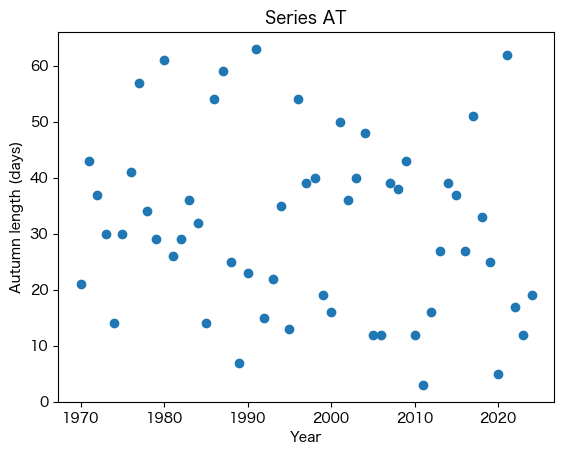

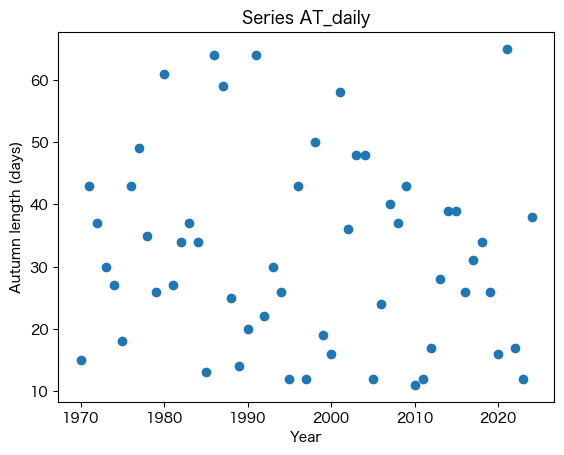

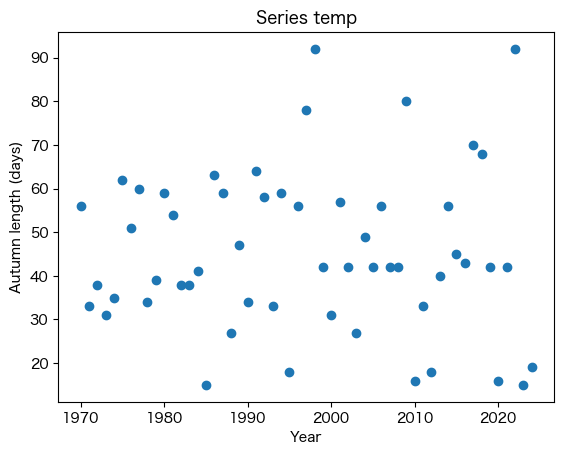

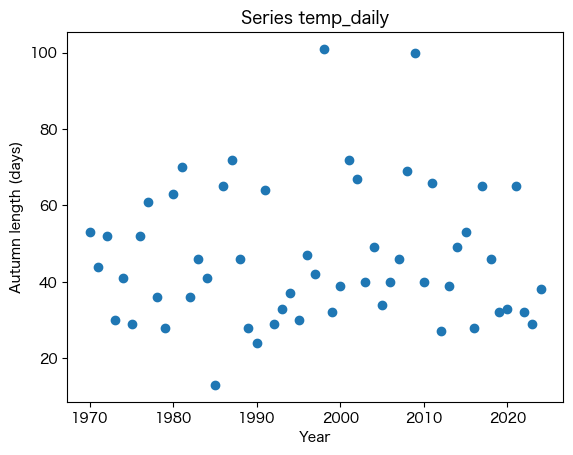

In [23]:
#fig, ax1 = plt.subplots(figsize=(10, 5))
for s in out_wide.columns.levels[1]:
    df_s = out_wide.xs(s, level="series", axis=1)
    fig, ax = plt.subplots()
    ax.plot(df_s.index, df_s["length_days"], linestyle="", marker="o")
    ax.set_title(f"Series {s}")
    ax.set_ylabel("Autumn length (days)")
    ax.set_xlabel("Year")
plt.show()

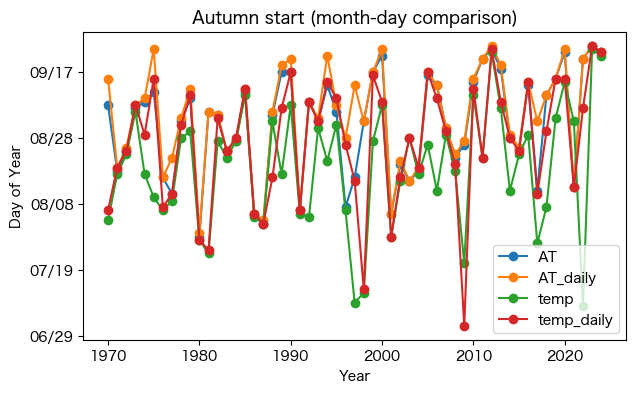

In [31]:
df = out_wide.xs("autumn_start", level=0, axis=1)
#df = out_wide.xs("autumn_start", level=0, axis=1)
#index : year (1970, 1971, ...)
#columns : series (AT, AT_daily, temp, temp_daily)
#values : datetime64[ns]

df_doy = df.apply(lambda s: s.dt.dayofyear)    # datetime=>DOY(day of year)
fig, ax = plt.subplots(figsize=(7, 4))

for col in df_doy.columns:
    ax.plot(df_doy.index, df_doy[col], marker="o", label=col)

ax.set_xlabel("Year")
ax.set_ylabel("Day of Year")
ax.set_title("Autumn start (month-day comparison)")
ax.legend()

import matplotlib.dates as mdates
from datetime import datetime

def doy_to_mmdd(doy):
    return datetime(2001, 1, 1) + pd.to_timedelta(doy - 1, unit="D")

ax.yaxis.set_major_formatter(
    lambda x, pos: doy_to_mmdd(int(x)).strftime("%m/%d")
)

plt.show()